# Intro

{Fill in with information about this notebook}

# Set Up notebook 

In [4]:
#Import modules
import numpy as np #Data manipulation
import pandas as pd #Point data manipulation and organization
import xarray as xr #Raster data manipulation and organization

import pathlib  #For filepaths, io, etc.
import os       #For several system-based commands
import datetime #For manipulation of time data, including file creation/modification times
import json     #For dictionary io, etc.

import matplotlib.pyplot as plt #For plotting and data vizualization
import geopandas as gpd         #For organization and manipulation of vector data in space (study area and some data points)
import rioxarray as rxr         #For orgnaization and manipulation of raster data
import shapely                  #For converting coordinates to point geometry

#Scripts with functions made for this specific application
from lib import readData    #For reading data 
from lib import mapping     #For geospatial data manipulation
from lib import cleanData   #For cleaning well data
from lib import classify    #For classifying well data
from lib import exportData  #For exporting data

#Variables needed throughout, best to just assign now
todayDate, dateSuffix = readData.getCurrentDate() 
repoDir = pathlib.Path(os.getcwd())

# Read in data

- Set up filepaths
- Read in data from:
    - downholeData table (from database)
    - headerData table (from database)
    - xyzData file (from previously carried out work) (will eventually make this updateable)

Read in data

In [3]:
directoryDir = r'\\isgs-sinkhole.ad.uillinois.edu\geophysics\Balikian\BedrockWellData\Wells\RawWellData_OracleDatabase\TxtData\\'[:-1]
downholeDataPATH, headerDataPATH, xyzInPATH  = readData.filesSetup(db_dir=directoryDir)

#Functions to read data into dataframes. Also excludes extraneous columns, and drops header data with no location information
headerDataIN, downholeDataIN = readData.readRawTxtData(downholefile=downholeDataPATH, headerfile=headerDataPATH) 
xyzDataIN = readData.readXYZData(xyzfile=xyzInPATH)

Most Recent version of this file is : ISGS_DOWNHOLE_DATA_2023-01-06.txt
Most Recent version of this file is : ISGS_HEADER_2023-01-06.txt
Most Recent version of this file is : xyzData.csv
Using the following files:

\\isgs-sinkhole.ad.uillinois.edu\geophysics\Balikian\BedrockWellData\Wells\RawWellData_OracleDatabase\TxtData\ISGS_DOWNHOLE_DATA_2023-01-06.txt
\\isgs-sinkhole.ad.uillinois.edu\geophysics\Balikian\BedrockWellData\Wells\RawWellData_OracleDatabase\TxtData\ISGS_HEADER_2023-01-06.txt
\\isgs-sinkhole.ad.uillinois.edu\geophysics\Balikian\BedrockWellData\Wells\RawWellData_OracleDatabase\TxtData\xyzData.csv
Downhole Data has 3054409 valid well records.
Header Data has 636855 unique wells with valid location information.


Define datatypes (doing this during the read in process has presented issues)

In [5]:
#Define datatypes, to read into defineDataTypes() function
##EVENTUALLY, MAKE THIS A FILE IN THE RES FOLDER TO READ IN
#downholeDataDTYPES = {'ID':np.uint32, "API_NUMBER":np.uint64,"TABLE_NAME":str,"WHO":str,"INTERPRET_DATE":str,"FORMATION":str,"THICKNESS":np.float64,"TOP":np.float64,"BOTTOM":np.float64}
#headerDataDTYPES = {'ID':np.uint32,'API_NUMBER':np.uint64,"TDFORMATION":str,"PRODFORM":str,"TOTAL_DEPTH":np.float64,"SECTION":np.float64,"TWP":np.float64,"TDIR":str,"RNG":np.float64,"RDIR":str,"MERIDIAN":np.float64,"FARM_NAME":str,"NSFOOT":np.float64,"NSDIR":str,"EWFOOT":np.float64,"EWDIR":str,"QUARTERS":str,"ELEVATION":np.float64,"ELEVREF":str,"COMP_DATE":str,"STATUS":str,"FARM_NUM":str,"COUNTY_CODE":np.float64,"PERMIT_NUMBER":str,"COMPANY_NAME":str,"COMPANY_CODE":str,"PERMIT_DATE":str,"CORNER":str,"LATITUDE":np.float64,"LONGITUDE":np.float64,"ENTERED_BY":str,"UPDDATE":str,"ELEVSOURCE":str, "ELEV_FT":np.float64}
#xyzDataDTYPES = {'ID':np.uint64, 'API_NUMBER':np.uint64, "LATITUDE":np.float64, "LONGITUDE":np.float64, "ELEV_FT":np.float64}

#Define datatypes of each column of the new dataframes
downholeDataIN = readData.defineDataTypes(downholeDataIN, dtypeFile='downholeDataTypes.txt')
headerDataIN = readData.defineDataTypes(headerDataIN, dtypeFile='headerDataTypes.txt')
xyzDataIN = readData.defineDataTypes(xyzDataIN, dtypeFile='xyzDataTypes.txt')

#Make a copy of the data so raw data is preserved while we work with the rest of the data
downholeData = downholeDataIN.copy()
headerData = headerDataIN.copy()
xyzData = xyzDataIN.copy()

c:\Users\riley\LocalData\Github\wells4hydrogeology\lib\readData.py:125: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:,i] = dfIN.iloc[:,i].astype(dtypes[dfIN.iloc[:,i].name])


Add in Control points

In [6]:
#NEED CODE HERE FOR ADDING IN CONTROL Wells MANUALLY
#Add control headerInfo
#Add control description info

# Extract Elevation Data

Extract elevation data from consistent elevation dataset for all wells (lidar or other statewide DEM)

In [7]:
#First, get wells with updated xyz info
    #Check first if xyzData needs to be updated with locations (?)
    #Check which wells in headerData don't have associated lidar data

#statewideLidar =  ow
#mapping.rastertoPoints_extract()

Merge elevation data with headerData table

In [8]:
uniqueWells = headerData['API_NUMBER'].unique()
#xyzData['UniqueWells'] = uniqueWells

headerData = mapping.addElevtoHeader(xyzData, headerData)
##NEED TO UPDATE THIS TO WORK WITH DATA WITH NO XYZ ELEVATION DATA FROM LIDAR
#Change xyz column name to indicate lidar
#Use order of preference: lidar, headerData table?/30/10m DEM?

# Data Cleaning

## First, let's clean up records in the data without the necessary information

Clip data from outside Study Area

Read in Study Area

In [9]:
studyAreaPath = r"\\isgs-sinkhole.ad.uillinois.edu\geophysics\Balikian\ISWS_HydroGeo\WellDataAutoClassification\SampleData\ESL_StudyArea_5mi.shp"
studyAreaIN, saExtent = mapping.readStudyArea(studyAreaPath)

In [10]:
headerData = mapping.coords2Geometry(df=headerData, xCol='LONGITUDE', yCol='LATITUDE', crs='EPSG:4269')
#headerData['geometry']=headerData['GEOMETRY'].copy() #old code
studyArea_4269 = studyAreaIN.to_crs('EPSG:4269').copy()
headerDataClip = gpd.clip(headerData, studyArea_4269) #Data from table is in EPSG:4269, easier to just project study area to ensure data fit
headerDataClip.reset_index(inplace=True, drop=True)
headerData = headerDataClip.copy()
headerData

c:\Users\riley\anaconda3\envs\geospatial38\lib\site-packages\geopandas\array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


,API_NUMBER,TOTAL_DEPTH,SECTION,TWP,TDIR,RNG,RDIR,MERIDIAN,QUARTERS,ELEVATION,ELEVREF,COUNTY_CODE,ELEVSOURCE,LATITUDE,LONGITUDE,ELEV_FT,geometry
0,13626212,201.0,15.0,2.0,N,5.0,W,3.0,NE NW NW,591.0,nan,27.0,nan,38.733337,-89.933357,580.419373,POINT (-89.93336 38.73334)
1,930917112,73.0,31.0,6.0,N,8.0,W,3.0,nan,537.0,GL,119.0,nan,38.930069,-90.030655,529.981140,POINT (-90.03065 38.93007)
2,930921712,75.0,25.0,6.0,N,9.0,W,3.0,SE,532.0,GL,119.0,nan,38.941998,-90.045364,530.172913,POINT (-90.04536 38.94200)
3,930921812,295.0,6.0,5.0,N,8.0,W,3.0,N2 SW NW,526.0,GL,119.0,nan,38.918377,-90.038200,520.954590,POINT (-90.03820 38.91838)
4,930921912,2195.0,23.0,5.0,N,8.0,W,3.0,SE,507.0,GL,119.0,nan,38.870552,-89.955078,507.976868,POINT (-89.95508 38.87055)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8145,1374073512,52.0,23.0,1.0,N,9.0,W,3.0,nan,NaN,nan,163.0,nan,38.520279,-90.058060,555.110840,POINT (-90.05806 38.52028)
8146,1374073812,70.0,33.0,2.0,N,9.0,W,3.0,SW NE SW,NaN,nan,163.0,nan,38.575832,-90.105003,409.501556,POINT (-90.10500 38.57583)
8147,1374073912,31.0,19.0,1.0,N,10.0,W,3.0,nan,413.0,DM,163.0,nan,38.528660,-90.244118,410.597595,POINT (-90.24412 38.52866)
8148,1374794512,61.0,12.0,2.0,N,9.0,W,3.0,NW,427.0,GL,163.0,nan,38.640568,-90.051552,431.323914,POINT (-90.05155 38.64057)


Now, remove data from downholeData table that does not have location information (Since we would not know where to put it anyway)

This should also essentially "clip" the downholeData to the study area, since only study area wells remain in headerData

In [11]:
downholeData = cleanData.removeNonlocatedData(downholeData, headerData)

2998078 records removed without location information.
56331 wells remain from 7188 located wells in study area.


Remove headerData rows without surface elevation information (this currently clips data from outside Illinois)

In [12]:
headerData =headerDataClip.copy()
headerData

,API_NUMBER,TOTAL_DEPTH,SECTION,TWP,TDIR,RNG,RDIR,MERIDIAN,QUARTERS,ELEVATION,ELEVREF,COUNTY_CODE,ELEVSOURCE,LATITUDE,LONGITUDE,ELEV_FT,geometry
0,13626212,201.0,15.0,2.0,N,5.0,W,3.0,NE NW NW,591.0,nan,27.0,nan,38.733337,-89.933357,580.419373,POINT (-89.93336 38.73334)
1,930917112,73.0,31.0,6.0,N,8.0,W,3.0,nan,537.0,GL,119.0,nan,38.930069,-90.030655,529.981140,POINT (-90.03065 38.93007)
2,930921712,75.0,25.0,6.0,N,9.0,W,3.0,SE,532.0,GL,119.0,nan,38.941998,-90.045364,530.172913,POINT (-90.04536 38.94200)
3,930921812,295.0,6.0,5.0,N,8.0,W,3.0,N2 SW NW,526.0,GL,119.0,nan,38.918377,-90.038200,520.954590,POINT (-90.03820 38.91838)
4,930921912,2195.0,23.0,5.0,N,8.0,W,3.0,SE,507.0,GL,119.0,nan,38.870552,-89.955078,507.976868,POINT (-89.95508 38.87055)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8145,1374073512,52.0,23.0,1.0,N,9.0,W,3.0,nan,NaN,nan,163.0,nan,38.520279,-90.058060,555.110840,POINT (-90.05806 38.52028)
8146,1374073812,70.0,33.0,2.0,N,9.0,W,3.0,SW NE SW,NaN,nan,163.0,nan,38.575832,-90.105003,409.501556,POINT (-90.10500 38.57583)
8147,1374073912,31.0,19.0,1.0,N,10.0,W,3.0,nan,413.0,DM,163.0,nan,38.528660,-90.244118,410.597595,POINT (-90.24412 38.52866)
8148,1374794512,61.0,12.0,2.0,N,9.0,W,3.0,NW,427.0,GL,163.0,nan,38.640568,-90.051552,431.323914,POINT (-90.05155 38.64057)


In [13]:
headerData = cleanData.removenotopo(df=headerData, printouts=True)

Well records removed: 0
Number of rows before dropping those without surface elevation information: 8150
Number of rows after dropping those without surface elevation information: 8150


Remove rows from downholeData with no depth information and where depth information is obviously bad (i.e., top depth > bottom depth)

In [14]:
#Drop records with no depth information
donwholeData = cleanData.dropnodepth(downholeData, printouts=True)
#Drop records with bad depth information (i.e., top depth > bottom depth) (Also calculates thickness of each record)
donwholeData = cleanData.dropbaddepth(downholeData, printouts=True)

Number of rows before dropping those without record depth information: 56331
Number of rows after dropping those without record depth information: 55747
Number of well records without formation information deleted: 584
Number of rows before dropping those with obviously bad depth information: 56331
Number of rows after dropping those with obviously bad depth information: 55725
Well records deleted: 606


Drop records with no FORMATION information

In [15]:
downholeData = cleanData.dropnoformation(downholeData, printouts=True)

Number of rows before dropping those without FORMATION information: 56331
Number of rows after dropping those without FORMATION information: 56331
Well records deleted: 0


Now we are going to export this data, to have record of cleaned data

In [16]:
downholeData.reset_index(inplace=True,drop=True)
headerData.reset_index(inplace=True,drop=True)

#downholeData.to_csv(str(repoDir)+'/out/downholeData_cleaned'+dateSuffix+'.csv',index_label='ID')
#headerData.to_csv(str(repoDir)+'/out/headerData_cleaned'+dateSuffix+'.csv',index_label='ID')

# Classification

The following flags are used to mark the classification method:
- 0: Not classified
- 1: Specific Search Term Match
- 2: Wildcard match (startTerm) - no context
- 3: Bedrock classification for obvious bedrock
- 4: Wildcard match (startTerm) - with context

In [17]:
#Read in dictionary files for downhole data
specTermsPATH, startTermsPATH = readData.searchTermFilePaths(dictdir=str(repoDir)+'/res/', specStartPattern='*SearchTerms-Specific*', startGlobPattern = '*SearchTerms-Start*')

Most Recent version of this file is : SearchTerms-Specific_2022-11-16_essCols.csv
Most Recent version of this file is : SearchTerms-Start.csv


In [18]:
specTerms, startTerms = readData.readSearchTerms(specfile=specTermsPATH, startfile=startTermsPATH)

c:\Users\riley\LocalData\Github\wells4hydrogeology\lib\readData.py:155: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  specTerms.iloc[:,i] = specTerms.iloc[:,i].astype(specTermsDtypes[specTerms.iloc[:,i].name])
c:\Users\riley\LocalData\Github\wells4hydrogeology\lib\readData.py:156: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  startTerms.iloc[:,i] = startTerms.iloc[:,i].astype(startTermsDtypes[startTerms.iloc[:,i].name])


Join the dataframes--for the specific search terms, this is the same as classifying them

In [19]:
downholeData_spec = classify.specificDefine(downholeData, specTerms, printouts=True)
downholeData = downholeData_spec.copy()

Records Classified with full search term: 25280
Records Classified with full search term: 44.88% of data


Create a dataframe with only the records already classified (using the specific search terms in this case, classifiedDF), and one that still needs to be searched (searchDF)

In [20]:
classifedDF, searchDF = classify.splitDefined(downholeData)
searchDF.shape[0]

31051

Now, do the classification routine on the searchDF database

In [21]:
searchDF = classify.startDefine(df=searchDF, starterms=startTerms, printouts=True)

Start Term process should be done by 10:55


c:\Users\riley\LocalData\Github\wells4hydrogeology\lib\classify.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CLASS_FLAG'].where(~df['FORMATION'].str.startswith(s,na=False),4,inplace=True)
c:\Users\riley\LocalData\Github\wells4hydrogeology\lib\classify.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['INTERPRETATION'].where(~df['FORMATION'].str.startswith(s,na=False),starterms.loc[i,'INTERPRETATION'],inplace=True)


Records classified with start search term: 3876
Records classified with start search term: 12.48% of remaining data


c:\Users\riley\LocalData\Github\wells4hydrogeology\lib\classify.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BEDROCK_FLAG'] = df["INTERPRETATION"] == 'BEDROCK'


Merge specDF and searchDF back together all back in single dataframe

In [22]:
downholeData_Terms = classify.remergeData(classifieddf=classifedDF, searchdf=searchDF)
downholeData = downholeData_Terms.copy()

Export terms that still need to be defined to csv (along with their counts)

In [23]:
#The outdir should be changed so it doesn't clog up the repository
#classify.export_toBeDefined(df=downholeData, outdir=str(repoDir)+'/out/')

Classify all  data under depth threshold (default is 550') as bedrock (should not be an issue, but just in case)

In [24]:
classifedDF, searchDF = classify.splitDefined(downholeData)
searchDF = classify.depthDefine(searchDF, thresh=550, printouts=True)
downholeData_Class = classify.remergeData(classifieddf=classifedDF, searchdf=searchDF)
downholeData = downholeData_Class.copy()

3.0    500
Name: CLASS_FLAG, dtype: int64
test
Records classified as bedrock that were deeper than 550': 500
This represents 1.84% of the unclassified data in this dataframe.


c:\Users\riley\LocalData\Github\wells4hydrogeology\lib\classify.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CLASS_FLAG'].mask(df['TOP']>thresh, 3 ,inplace=True) #Add a Classification Flag of 3 (bedrock b/c it's deepter than 550') to all records where the top of the interval is >550'
c:\Users\riley\LocalData\Github\wells4hydrogeology\lib\classify.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BEDROCK_FLAG'].mask(df['TOP']>thresh, True, inplace=True)


Add '0' flag for data still not classified

In [25]:
downholeData = classify.fillUnclassified(downholeData)

In [26]:
downholeData['CLASS_FLAG'].value_counts()

0.0    26675
1.0    25280
4.0     3876
3.0      500
Name: CLASS_FLAG, dtype: int64

## Add "Flag" for target interpratations

In [27]:
#dictDir = "\\\\isgs-sinkhole\\geophysics\\Balikian\\ISWS_HydroGeo\\WellDataAutoClassification\\SupportingDocs\\"
targetInterpDF = readData.readLithologies()

In [28]:
downholeData = classify.mergeLithologies(downholedata=downholeData, targinterps=targetInterpDF)

Flags used for target classification purposes:
- -2: No classification 
- -1: Classified, not used/not definitive
- 0: Classified, not target material
- 1: Classified as target material

In [29]:
downholeData['TARGET'].value_counts()

-2    27217
-1    14452
0     10637
1      4025
Name: TARGET, dtype: int64

Find all unique wells in downhole dataset

In [30]:
#Get Unique well APIs
wellsDF = classify.getUniqueWells(downholeData)

Number of unique wells in downholeData: 7188


Sort dataset by API Number and Depth of top of record (will be easier to do data analysis with records in the correct order)

In [31]:
downholeData_sorted = downholeData.sort_values(['API_NUMBER','TOP'])
downholeData_sorted.reset_index(inplace=True)
downholeData_sorted

,index,API_NUMBER,TABLE_NAME,FORMATION,THICKNESS,TOP,BOTTOM,INTERPRETATION,CLASS_FLAG,BEDROCK_FLAG,TARGET,Unnamed: 2,MUD
0,0,13626212,WFORMATIONS,clay brown,20.0,0.0,20.0,CLAY,1.0,False,0,NaN,SAND AND CLAY
1,2,13626212,WFORMATIONS,"clay gray sandy, soft",20.0,20.0,40.0,NaN,0.0,False,-2,NaN,NaN
2,3,13626212,WFORMATIONS,"clay gray, sticky",4.0,40.0,44.0,NaN,0.0,False,-2,NaN,NaN
3,1,13626212,WFORMATIONS,"clay dark brown, wood",6.0,44.0,50.0,NaN,0.0,False,-2,NaN,NaN
4,7,13626212,WFORMATIONS,shale gray sandy hard,64.0,50.0,114.0,BEDROCK,1.0,True,-1,NaN,DIRT AND GRAVEL
...,...,...,...,...,...,...,...,...,...,...,...,...,...
56326,56324,1374794512,HWYBRIDGE_LOG,brown and gray silty clay,5.0,21.5,26.5,SILT,1.0,False,0,NaN,NaN
56327,56328,1374794512,HWYBRIDGE_LOG,gray clay (with thin sand streaks),7.5,26.5,34.0,NaN,0.0,False,-2,NaN,NaN
56328,56322,1374794512,HWYBRIDGE_LOG,blue-gray clay,5.0,34.0,39.0,NaN,0.0,False,-2,NaN,NaN
56329,56329,1374794512,HWYBRIDGE_LOG,"gray, fine sand",5.0,39.0,44.0,NaN,0.0,False,-2,NaN,NaN


# Get Bedrock Depth and Layer Thickness

Read in/Define Model Grid

In [32]:
modelGridPath = r"\\isgs-sinkhole.ad.uillinois.edu\geophysics\Balikian\ISWS_HydroGeo\WellDataAutoClassification\SampleData\grid_625_raster.tif"
modelGrid = mapping.readModelGrid(studyArea=studyAreaIN, gridpath=modelGridPath, nodataval=0, readGrid=True, clip2SA=True, gridcrs='EPSG:26715', studyAreacrs='EPSG:26715')

Read in surface elevation grid

In [33]:
surfaceElevPath = r"\\isgs-sinkhole.ad.uillinois.edu\geophysics\Balikian\ISWS_HydroGeo\WellDataAutoClassification\SampleData\ILStateLidar_ClipExtentESL.tif"
surfaceElevGridIN = mapping.readSurfaceGrid(surfaceelevpath=surfaceElevPath, useWCS=False, studyArea=studyAreaIN, clip2SA=True)

Read in bedrock elevation grid

In [34]:
bedrockElevPath = r"\\isgs-sinkhole.ad.uillinois.edu\geophysics\Balikian\ISWS_HydroGeo\WellDataAutoClassification\SampleData\ESLBedrock.tif"
bedrockElevGridIN=mapping.readBedrockGrid(bedrockelevpath=bedrockElevPath, studyArea=studyAreaIN, clip2SA=True)

Plot just to see them

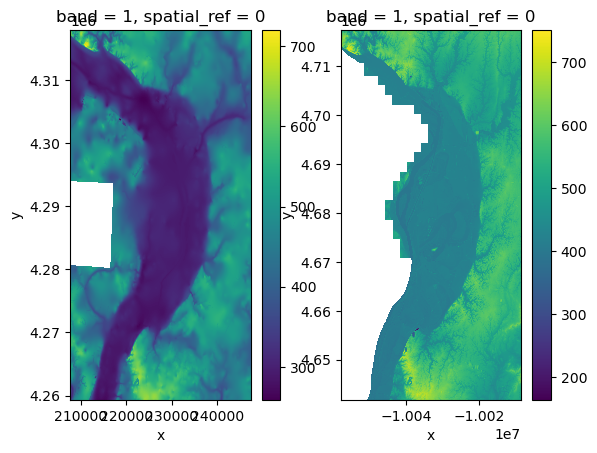

In [ ]:
#fig, ax = plt.subplots(ncols = 2, nrows=1)
#bedrockElevGridIN.plot(ax=ax[0])
#surfaceElevGridIN.plot(ax=ax[1])

Reproject and align raster grids for surface elevation and bedrock topo (reproject well data too if needed)

In [ ]:
inGrids = [bedrockElevGridIN, surfaceElevGridIN]
bedrockGrid, surfaceGrid = mapping.alignRasters(unalignedGrids=inGrids, modelgrid=modelGrid)

fig, ax = plt.subplots(ncols = 2, nrows=1)
bedrockGrid.plot(ax=ax[0])
surfaceGrid.plot(ax=ax[1])

Use the surface elevation raster and bedrock elevation raster to get depth to bedrock

In [47]:
driftThickGrid.data.min()

nan

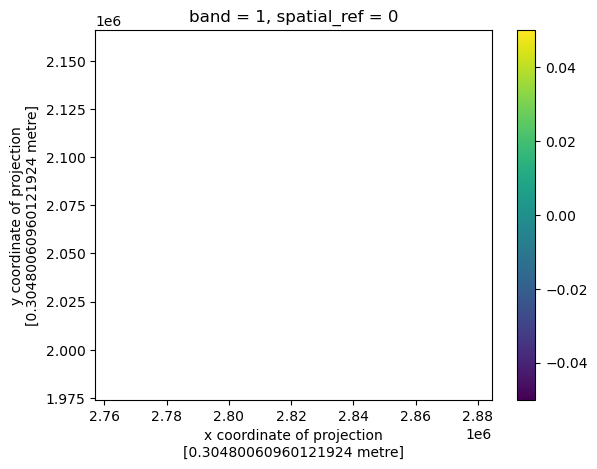

In [40]:
driftThickGrid, layerThickGrid = mapping.getDriftThick(surface=surfaceGrid, bedrock=bedrockGrid, noLayers=9, plotData=True)

Now, sample each well point (headerData) to get layer thickness, surface elevation, and bedrock 

In [ ]:
headerData = mapping.rastertoPoints_sample(raster=bedrockGrid, ptDF=headerData, newColName='BEDROCK_ELEV_FT')
headerData['BEDROCK_ELEV_M'] = headerData['BEDROCK_ELEV_FT']* 0.3048

headerData = mapping.rastertoPoints_sample(raster=surfaceGrid, ptDF=headerData, newColName='SURFACE_ELEV_FT')
headerData['SURFACE_ELEV_M'] = headerData['SURFACE_ELEV_FT']* 0.3048

headerData = mapping.rastertoPoints_sample(raster=layerThickGrid, ptDF=headerData, newColName='LAYER_THICK_FT')
headerData['LAYER_THICK_M'] = headerData['LAYER_THICK_FT']* 0.3048

Calculate  all layer depths/elevations at all wells

In [ ]:
noLayers = 9
for layer in range(0, noLayers): #For each layer
    #Make column names
    depthColName  = 'Depth_FT_LAYER'+str(layer)
    depthMcolName = 'Depth_M_LAYER'+str(layer) 

    elevColName = 'ELEV_FT_LAYER'+str(layer)
    elevMColName = 'ELEV_M_LAYER'+str(layer)
    
    #Calculate depth to each layer at each well, in feet and meters
    headerData[depthColName]  = headerData['Layer_Thick_FT'] * layer
    headerData[depthMcolName] = headerData[depthColName] * 0.3048
    
    headerData[elevColName]  = headerData['SURFACE_ELEV_FT'] - headerData['Layer_Thick_FT'] * layer
    headerData[elevMColName]  = headerData['SURFACE_ELEV_M'] - headerData['Layer_Thick_M'] * layer


# Work here next!

Define function to calculate target thickness in each layer

In [ ]:
##THIS CELL MAY NEED TO BE UPDATED!!!!!


#Define the function to export the result of thickness of target sediments in each layer
def Layers_surfacedown(df, layer = 1):
    
    #Generate Column names based on (looped) integers
    topCol = "ESL_ModelTopoLyrs_"+str(layer)
    if layer != 9: #For all layers except the bottom layer....
        botCol = "ESL_ModelTopoLyrs_"+str(layer+1) #use the layer below it to 
    else: #Otherwise, ...
        botCol = "BedrockCorr" #Use the (corrected) bedrock depth

    #Divide records into 4 separate categories for ease of calculation, to be joined back together later  
        #Category 1: Well interval starts above layer top, ends within model layer
        #Category 2: Well interval is entirely contained withing model layer
        #Category 3: Well interval starts within model layer, continues through bottom of model layer
        #Category 4: well interval begins and ends on either side of model layer (model layer is contained within well layer)

    #records1 = intervals that go through the top of the layer and bottom is within layer
    records1 = df.loc[(df['TOP_ELEV_ft'] > df[topCol]) & (df['BOT_ELEV_ft'] > df[botCol]) & (df['BOT_ELEV_ft'] <= df[topCol]) & (df['BOT_ELEV_ft'] <= df['TOP_ELEV_ft'])].copy()
    records1['TARG_THICK'] = pd.DataFrame(np.round((records1.loc[:,topCol]-records1.loc[: , 'BOT_ELEV_ft']) * records1['Target'],3)).copy()
    
    #records2 = entire interval is within layer
    records2 = df.loc[(df['TOP_ELEV_ft'] <= df[topCol]) & (df['BOT_ELEV_ft'] >= df[botCol]) & (df['BOT_ELEV_ft'] <= df['TOP_ELEV_ft'])].copy()
    records2['TARG_THICK'] = pd.DataFrame(np.round((records2.loc[: , 'TOP_ELEV_ft'] - records2.loc[: , 'BOT_ELEV_ft']) * records2['Target'],3)).copy()

    #records3 = intervals with top within layer and bottom of interval going through bottom of layer
    records3 = df.loc[(df['TOP_ELEV_ft'] > df[botCol]) & (df['BOT_ELEV_ft'] < df[botCol]) & (df['TOP_ELEV_ft'] <= df[topCol]) & (df['BOT_ELEV_ft'] <= df['TOP_ELEV_ft'])].copy()
    records3['TARG_THICK'] = pd.DataFrame(np.round((records3.loc[: , 'TOP_ELEV_ft'] - (records3.loc[:,botCol]))*records3['Target'],3)).copy()

    #records4 = interval goes through entire layer
    records4 = df.loc[(df['TOP_ELEV_ft'] > df[topCol]) & (df['BOT_ELEV_ft'] < df[botCol]) & (df['BOT_ELEV_ft'] <= df['TOP_ELEV_ft'])].copy()
    records4['TARG_THICK'] = pd.DataFrame(np.round((records4.loc[: , topCol]-records4.loc[: , botCol]) * records4['Target'],3)).copy()

    
    #Put the four calculated record categories back together into single dataframe
    res = records1.append(records2).append(records3).append(records4)
    
    res_df = res.groupby(['API_NUMBER','LATITUDE','LONGITUDE'],as_index=False).sum()#calculate thickness for each well interval in the layer indicated (e.g., if there are two well intervals from same well in one model layer)

    res_df['TARG_THICK_PER'] = pd.DataFrame(np.round(res_df['TARG_THICK']/res_df['LyrThick'],3)) #Calculate thickness as percent of total layer thickness
    res_df["LAYER"] = layer #Just to have as part of the output file, include the present layer in the file itself as a separate column
    res_df = res_df[['API_NUMBER', 'LATITUDE', 'LONGITUDE', 'TOP', 'BOTTOM','SURF_ELEV_ft', 'TOP_ELEV_ft', 'BOT_ELEV_ft',topCol,botCol,'LyrThick','TARG_THICK', 'TARG_THICK_PER', 'LAYER']].copy() #Format dataframe for output
    
    return res, res_df

Now run that function over all the layers, looping through each one

In [ ]:
#THIS CELL WILL NEED TO BE UPDATED

outDIR = "\\\\isgs-sinkhole\\geophysics\\Balikian\\ISWS_HydroGeo\\MetroEast_HydroGeo\\CodeOutput\\"+codeTarget+"\\"

for i in np.arange(1,10):
    res, res_df = Layers_surfacedown(df, layer = i)#Run the function defined above for each layer
    outputname = codeTargShort+'Lyr'+str(i)+'.csv' #Create a filename based on the layer and target
    res_df.to_csv(outDIR+outputname)  #Export the file to csv
    #Could also potentially save these to variables for use in following cells

# Interpolate thickness values in each layer

Loop through each layer and interpolate (use same parameters (?))

Ensure rasters align (are co-registered) with grid

# Export

In [ ]:
#Export data 
downhole_bedrockDepth_XYZ.to_csv('\\\\isgs-sinkhole\\geophysics\\Balikian\\BedrockWellData\\Wells\\ProcessedWellData\\Downhole_BedrockPicks.csv',index_label="ID")
wPermits_XYZ.to_csv('\\\\isgs-sinkhole\\geophysics\\Balikian\\BedrockWellData\\Wells\\ProcessedWellData\\wPermits_BedrockPicks.csv',index_label="ID")